In [1]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
import gensim.models as genmodels
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df = pickle.load(open("../data/merged_hotel_data.pkl", "rb"))
df=df.replace(r'^\s*$', np.nan, regex=True)
print(df.shape)
#df.head()


(76536, 31)


In [4]:
default_comments=["Exceptional", "Very Good", "Wonderful", "Good", "Pleasant","Fair", "Disappointing","Bad", "Poor",
                 "Excellent", "Very Poor", "Okay", "Great","Very Good","Ok"]

pattern = '|'.join(default_comments)
df_reviews_sr=df[["short_review"]].dropna()
df_reviews_sr=df_reviews_sr[~df_reviews_sr.short_review.str.contains(pattern)]
df_reviews_sr

,short_review
0,Ilike The place
1,average
2,okay
6,Practically okay
7,"convenient location, price is good"
...,...
76447,Thank you sa pag stay ko sa hotel 88 courtyard
76448,Wifi很差！
76449,Anche no!!
76459,Can I disparage the 88 to discourage people f...


In [5]:
# Convert to list 
data = df_reviews_sr.short_review.values.tolist()  
# # Remove Emails 
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# # Remove new line characters 
# data = [re.sub('\s+', ' ', sent) for sent in data]  
# # Remove distracting single quotes 
# data = [re.sub("\'", "", sent) for sent in data]
# #Remove \n
# data = [re.sub("\n", "", sent) for sent in data]
# data = [re.sub("(Image courtesy: )", "", sent) for sent in data]
# #Remove links
# data = [re.sub(r'http\S+', '', sent) for sent in data]
display(len(data))
print(data[8])

17045

 good 


### Tokenization

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:9]) 

[['ilike', 'the', 'place'], ['average'], ['okay'], ['practically', 'okay'], ['convenient', 'location', 'price', 'is', 'good'], ['been', 'visited', 'many', 'countries', 'for', 'tour', 'and', 'your', 'hotel', 'is', 'very', 'nice', 'place', 'to', 'stay', 'thank', 'you'], ['peaceful'], ['practicality', 'yet', 'comfty'], ['good']]


### Building the bigram and trigram Models

In [7]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)


In [8]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[8]]])

['good']


### Define function for stopwords, bigrams, trigrams and lemmatization

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


In [11]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

#nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bi = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
data_lemmatized_tri = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])
print(data_lemmatized_bi[-1])

C:\Users\colee\anaconda3\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


['hotel', 'staff', 'thank']


In [12]:
len(data_lemmatized_bi)

17045

In [13]:
id2word_bi = corpora.Dictionary(data_lemmatized_bi)  
id2word_tri = corpora.Dictionary(data_lemmatized_tri)  

In [14]:
texts_bi = data_lemmatized_bi
texts_tri = data_lemmatized_tri

In [15]:
# Term Document Frequency 
corpus_bi = [id2word_bi.doc2bow(text) for text in texts_bi]  
corpus_tri = [id2word_tri.doc2bow(text) for text in texts_tri]  

In [16]:
# View 
print(corpus_bi[:8])

[[(0, 1)], [], [], [], [(1, 1), (2, 1), (3, 1)], [(0, 1), (4, 1), (5, 1), (6, 1)], [], [(7, 1), (8, 1)]]


In [17]:
[[(id2word_bi[id], freq) for id, freq in cp] for cp in corpus_bi[:1]]
[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri[:1]]

[[('place', 1)]]

<AxesSubplot:ylabel='word'>

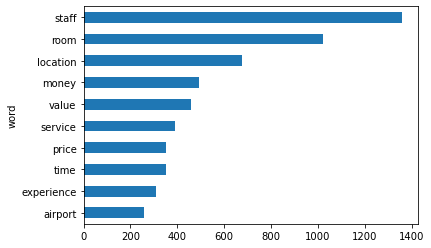

In [18]:
bow=[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri]
flat_list = [item for sublist in bow for item in sublist]


no_value_words=["stay","good","hotel","place","nice","great"]

df_bow = pd.DataFrame(flat_list, columns = ['word', 'count'])
df_bow=df_bow[~df_bow.word.str.contains('|'.join(no_value_words))] 
df_bow.groupby("word")["count"].sum().sort_values(ascending=True).tail(10).plot.barh()

### Noun Chunks

In [19]:
data2 = data.copy()

In [20]:
import spacy
nlp = spacy.load('en_core_web_md')

chunks = []
for i in data2:
    doc = nlp(i)

    for chunk in doc.noun_chunks:
        out = {}
        root = chunk.root
        out[root.pos_] = root
        for tok in chunk:
            if tok != root:
                out[tok.pos_] = tok
        chunks.append(out)

In [21]:
chunks

[{'NOUN': place, 'DET': The},
 {'NOUN': location, 'ADJ': convenient},
 {'NOUN': price},
 {'PRON': I, 'SPACE':  },
 {'NOUN': countries, 'ADJ': many},
 {'NOUN': tour, 'DET': a},
 {'NOUN': hotel, 'PRON': your},
 {'NOUN': place, 'DET': a, 'ADV': very, 'ADJ': nice},
 {'PRON': you},
 {'PROPN': practicality, 'SPACE':  },
 {'PROPN': comfty},
 {'PRON': I},
 {'NOUN': experience, 'DET': all},
 {'NOUN': waste},
 {'NOUN': money},
 {'NOUN': place, 'SPACE':  , 'DET': The},
 {'NOUN': renovation, 'DET': a, 'ADJ': serious},
 {'PRON': I, 'SPACE':  },
 {'NOUN': bed, 'SPACE':  , 'ADJ': Comfortable},
 {'NOUN': room, 'ADJ': clean},
 {'NOUN': staff, 'ADJ': great},
 {'NOUN': staff, 'SPACE':  , 'ADJ': friendly, 'PUNCT': ,, 'CCONJ': and},
 {'PROPN': Home, 'SPACE':  },
 {'NOUN': budget, 'PUNCT': -, 'ADJ': friendly},
 {'NOUN': location, 'ADJ': great},
 {'NOUN': budget, 'PRON': our},
 {'NOUN': nightmare, 'SPACE':  , 'DET': a},
 {'PRON': I, 'SPACE':  },
 {'NOUN': place, 'DET': this},
 {'PRON': It},
 {'NOUN': experie

In [22]:
df_chunk = pd.DataFrame.from_dict(chunks)

In [23]:
df_chunk['NOUN'] = df_chunk['NOUN'].astype(str)
df_chunk['ADJ'] = df_chunk['ADJ'].astype(str)

In [86]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return(lemmatizer.lemmatize(text))

df_chunk['NOUN_lemma'] = df_chunk.NOUN.apply(lemmatize_text)
df_chunk['ADJ_lemma'] = df_chunk.ADJ.apply(lemmatize_text)

In [99]:
def lower_text(text):
    return(text.lower())

df_chunk['NOUN_lemma'] = df_chunk.NOUN.apply(lower_text)
df_chunk['ADJ_lemma'] = df_chunk.ADJ.apply(lower_text)

In [87]:
df_chunk['NOUN_lemma'] = df_chunk['NOUN_lemma'].astype(str)
df_chunk['ADJ_lemma'] = df_chunk['ADJ_lemma'].astype(str)
df_chunk['NOUN_lemma'] = df_chunk['NOUN_lemma'].str.lower()
df_chunk['ADJ_lemma'] = df_chunk['ADJ_lemma'].str.lower()

In [80]:
df_chunk['NOUN_lemma'] = df_chunk['NOUN_lemma'].astype(str)

In [88]:
df_chunk

,NOUN,DET,ADJ,PRON,SPACE,ADV,PROPN,PUNCT,CCONJ,NUM,...,AUX,PART,X,INTJ,ADP,SYM,SCONJ,NOUN_lemma,ADJ_lemma,nounstring
0,place,The,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,place,nan,"[,',p,l,a,c,e,',]"
1,location,NaN,convenient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,location,convenient,"[,',l,o,c,a,t,i,o,n,',]"
2,price,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,price,nan,"[,',p,r,i,c,e,',]"
3,nan,NaN,nan,I,,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,"[,',n,a,n,',]"
4,countries,NaN,many,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,country,many,"[,',c,o,u,n,t,r,y,',]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31523,people,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,people,nan,"[,',p,e,o,p,l,e,',]"
31524,gem,this,hidden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gem,hidden,"[,',g,e,m,',]"
31525,hotel,NaN,Nice,NaN,,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hotel,nice,"[,',h,o,t,e,l,',]"
31526,staff,NaN,great,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,staff,great,"[,',s,t,a,f,f,',]"


# TOP ADJECTIVES DESCRIBING TOP NOUNS

STAFF

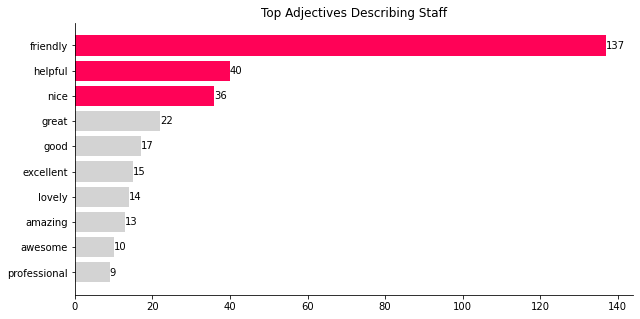

In [104]:
staff =  df_chunk[(df_chunk['NOUN_lemma'] == 'staff') & (df_chunk['ADJ_lemma'] != 'nan')]
staff = staff[['NOUN_lemma','ADJ_lemma']]


staff_adj = pd.DataFrame({'trans_count': staff['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(staff_adj.index, staff_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Staff')
ax.bar_label(hbar)
plt.show()

ROOM

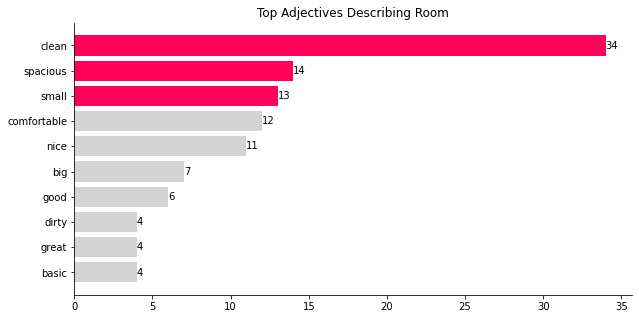

In [105]:
room =  df_chunk[(df_chunk['NOUN_lemma'] == 'room') & (df_chunk['ADJ_lemma'] != "nan")]
room = room[['NOUN_lemma','ADJ_lemma']]


room_adj = pd.DataFrame({'trans_count': room['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(room_adj.index, room_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Room')
ax.bar_label(hbar)
plt.show()

LOCATION

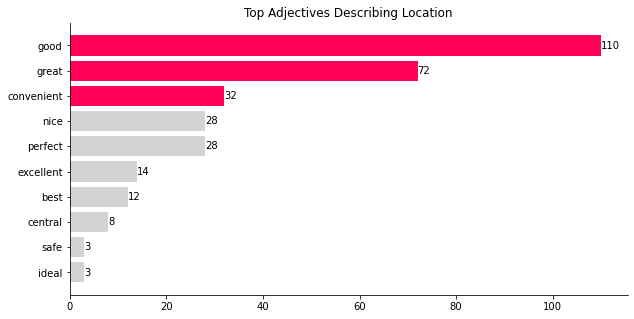

In [107]:
loct =  df_chunk[(df_chunk['NOUN_lemma'] == 'location') & (df_chunk['ADJ_lemma'] != "nan")]
loct = loct[['NOUN_lemma','ADJ_lemma']]


loct_adj = pd.DataFrame({'trans_count': loct['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(loct_adj.index, loct_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Location')
ax.bar_label(hbar)
plt.show()

SERVICE

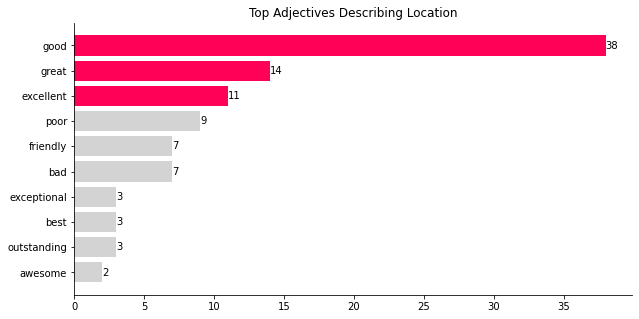

In [113]:
mon =  df_chunk[(df_chunk['NOUN_lemma'] == 'service') & (df_chunk['ADJ_lemma'] != "nan")]
mon = mon[['NOUN_lemma','ADJ_lemma']]


mon_adj = pd.DataFrame({'trans_count': mon['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(mon_adj.index, mon_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Location')
ax.bar_label(hbar)
plt.show()

PRICE

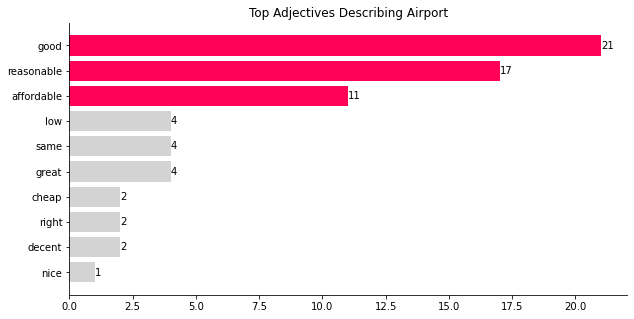

In [114]:
apt =  df_chunk[(df_chunk['NOUN_lemma'] == 'price') & (df_chunk['ADJ_lemma'] != "nan")]
apt = apt[['NOUN_lemma','ADJ_lemma']]


apt_adj = pd.DataFrame({'trans_count': apt['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(apt_adj.index, apt_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Airport')
ax.bar_label(hbar)
plt.show()